In [20]:
import os
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import scipy
import matplotlib.pyplot as plt

#--------------------- INSAR4SM functionalities --------------
from insar4sm.classes import INSAR4SM_stack, SM_point
from insar4sm.joblib_progress_bar import tqdm_joblib

In [16]:
def sm_estimation(stack:INSAR4SM_stack, sm_ind:int, dry_date_manual_flag:bool, dry_date: str)->np.array:
    """Estimates soil moisture using insar4sm functionalities

    Args:
        stack (INSAR4SM_stack): the object of the INSAR4SM_stack class
        sm_ind (int): index of soil moisture estimation point

    Returns:
        np.array: soil moisture estimations from inversion
    """
    sm_point_ts = SM_point(stack, sm_ind)
    sm_point_ts.get_DS_info(stack)
    sm_point_ts.calc_covar_matrix()
    if sm_point_ts.non_coverage or np.all(sm_point_ts.amp_DS==0):
        return np.full(sm_point_ts.n_ifg, np.nan)
    else:
        sm_point_ts.get_DS_geometry(stack)
        sm_point_ts.calc_driest_date()
        if dry_date_manual_flag:
            sm_point_ts.driest_date = pd.to_datetime(dry_date)
        sm_point_ts.calc_sm_sorting()
        sm_point_ts.calc_sm_coherence()
        sm_point_ts.calc_sm_index()
        sm_point_ts.inversion()
        return sm_point_ts.sm_inverted

Input arguments for Arabia case study

In [17]:
# the name of your project
projectname = 'INSAR4SM_estimations_r1_v2'

# the directory of the topstack processing stack
topstackDir = '/RSL02/SM_Arabia/Topstack_processing'

# time of Sentinel-1 pass.
orbit_time = '15:00:00'

# the AOI geojson file, ensure that AOI is inside your topstack stack
AOI = '/RSL02/SM_Arabia/aoi/arabia_r1_2.geojson'

# spatial resolution of soil moisture grid in meters
grid_size = 250 

# You can set manually a dry date (one of your SAR acquisition dates ) or set to None
dry_date = '20180401' 
# set to True in case you provide manually an dry_date
dry_date_manual_flag = True

# the meteorological file. You can either provide an ERA5-land file or a csv file with 3 columns (Datetimes, tp__m, skt__K).
meteo_file = '/RSL02/SM_Arabia/era5/adaptor.mars.internal-1665654570.8663068-23624-3-8bce5925-a7e7-4993-a701-0e05b4e9dabd.nc'
# set to True in case you provide an ERA5-Land file
ERA5_flag = True
# In case you downloaded surface soil moisture from ERA5-land, set to True for comparison purposes
ERA5_sm_flag = True

# soil information datasets (https://soilgrids.org/)
sand_soilgrids = '/RSL02/SM_Arabia/soilgrids/clay.tif'
clay_soilgrids = '/RSL02/SM_Arabia/soilgrids/sand.tif'

# the output directory 
export_dir = '/RSL02/SM_Arabia/{}'.format(projectname)

InSAR4SM pipeline

In [18]:
stack = INSAR4SM_stack(topstackDir = topstackDir,
                       projectname = projectname,
                       AOI = AOI,
                       meteo_file = meteo_file,
                       ERA5_flag = ERA5_flag,
                       sand = sand_soilgrids,
                       clay = clay_soilgrids,
                       orbit_time = orbit_time,
                       export_dir = export_dir)

stack.prepare_datasets()
stack.plot()
stack.get_dry_SARs()
stack.calc_insar_stack()
stack.calc_grid(grid_size = grid_size)

with tqdm_joblib(tqdm(desc="SM Invertions", total=stack.n_sm_points)) as progress_bar:
    sm_estimations_list = Parallel(n_jobs=stack.CPUs, backend="threading")(delayed(sm_estimation)(stack, sm_ind, dry_date_manual_flag, dry_date) for sm_ind in range(stack.n_sm_points))

column_dates = [slc_date.strftime("D%Y%m%d") for slc_date in stack.slc_datetimes]
sm_estimations_df = pd.DataFrame(sm_estimations_list, index = range(stack.n_sm_points), columns = column_dates)

sm_estimations_df['geometry'] = stack.sm_points.values
sm_estimations_gdg = gpd.GeoDataFrame(sm_estimations_df, geometry='geometry')
sm_estimations_gdg.to_file(os.path.join(stack.export_dir,'sm_inversions_{}_{}.shp'.format(projectname,grid_size)))

number of SLCs discovered:  21
creating directory: /RSL02/SM_Arabia/INSAR4SM_estimations_r1_v2/INSAR4SM_estimations_r1_v2/INSAR4SM_datasets/slcs
write vrt file for each SLC ...
creating stack directory: /RSL02/SM_Arabia/INSAR4SM_estimations_r1_v2/INSAR4SM_estimations_r1_v2/INSAR4SM_datasets/coreg_stack
write vrt file for stack directory
creating geometry directory: /RSL02/SM_Arabia/INSAR4SM_estimations_r1_v2/INSAR4SM_estimations_r1_v2/INSAR4SM_datasets/geometry
write vrt file for geometry dataset


SM Invertions: 100%|██████████| 1904/1904 [2:19:08<00:00,  4.38s/it]  


Comparison with ERA5 soil moisture data

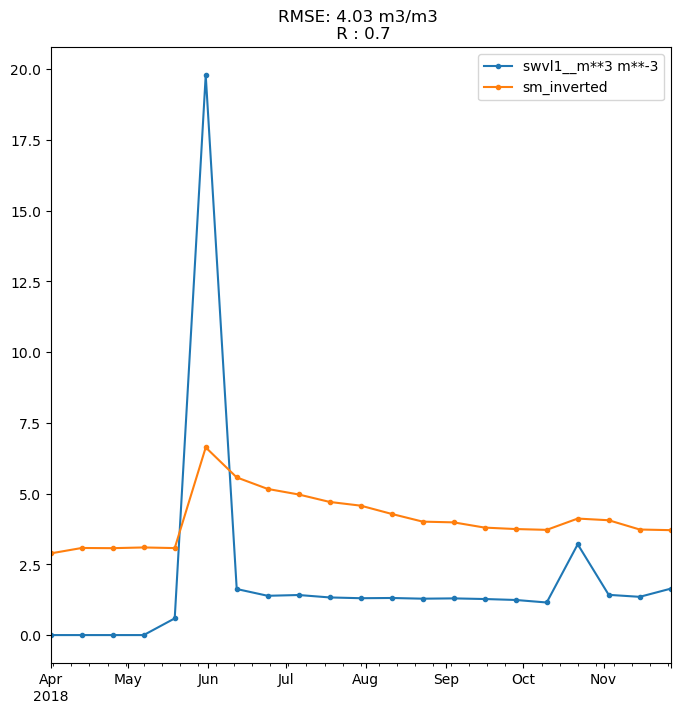

In [24]:
if ERA5_sm_flag:
    comparison_df = (stack.meteo_sel_df['swvl1__m**3 m**-3']*100).copy().to_frame()
    
    sm_estimations_df.dropna(inplace=True)
    #sm_estimations_df.drop(columns='geometry', inplace=True)
    comparison_df['sm_inverted'] = sm_estimations_df.mean(axis=0).values
    comparison_df.to_csv('{}/comparison_{}.csv'.format(stack.export_dir, grid_size), index=False)
    
    predictions = comparison_df['swvl1__m**3 m**-3'].values
    targets = comparison_df['sm_inverted'].values
    n = predictions.shape[0]
    rmse = np.linalg.norm(predictions - targets) / np.sqrt(n)
    r, p = scipy.stats.pearsonr(predictions, targets)
    
    comparison_df.plot(figsize=(8,8), style='.-')
    plt.title('RMSE: {} m3/m3 \n R : {}'.format(round(rmse,2), round(r,2)))
    plt.savefig('{}/ERA5_comparison_{}.png'.format(stack.export_dir, grid_size), dpi=200)
    #plt.close()

In [11]:
rmse

4.660319703005047